# Hands-on session 2 - Autoregressive Models
## Generative Modeling Summer School 2023

#### Instructions on how to use this notebook:

This notebook is hosted on ``Google Colab``. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using ``Colab`` entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using **Colab** is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because, for various models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default ``Colab`` runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from 5GB to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, ``Google Colab`` does not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others or make multiple copies of the notebook to work concurrently.

**Submission:** Please bring your (partial) solution to the hands-on session. Then you can discuss it with the intructors and your colleagues.

In [19]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Introduction

In this assignment, we are going to implement an Autoregressive Model (ARM). An ARM is a likelihood-based deep generative model that is parameterized by causal convolutional neural networks or causal transformers. Here, we focus on causal convolutions. The approach of parameterizing ARMs with causal convolutions was utilized in multiple papers, e.g.:
- [Van den Oord, Aaron, et al. "Conditional image generation with pixelcnn decoders." NeurIPS 29 (2016).](https://proceedings.neurips.cc/paper/6527-conditional-image-generation-with-pixelcnn-decoders)
- [Oord, Aaron van den, et al. "Wavenet: A generative model for raw audio." arXiv preprint arXiv:1609.03499 (2016).](https://arxiv.org/abs/1609.03499)

You can read more about ARMs in Chapter 2 of the following book:
- [Tomczak, J.M., "Deep Generative Modeling", Springer, 2022](https://link.springer.com/book/10.1007/978-3-030-93158-2)

In particular, the goals of this assignment are the following:

- Understand how ARMs are formulated
- Implement causal convolutions and ARMs using PyTorch
- Train and evaluate a model for image data

### Theory behind ARMs

ARMs are probabilistic models that utilize factorization of joint distribution in the following manner:
$$
p(\mathbf{x}) = \prod_{d=1}^{D} p(x_d | \mathbf{x}_{1:d-1}) .
$$

Then the log-likelihood function is the following:
$$
\ln p(\mathbf{x}) = \sum_{d=1}^{D} \ln p(x_d | \mathbf{x}_{1:d-1}) .
$$

This is very convenient because we *only* need to model conditionals. The challenge though is how to allow learning long-range dependencies (a *long-term memory*).

One possible way of accomplishing that is by utilizing **causal convolutions**. Then, we can use a convolutional neural network that predicts the parameters of the conditionals in a single forward run!  

## IMPORTS

In [20]:
# DO NOT REMOVE!
import os

import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST

!pip install pytorch_model_summary
from pytorch_model_summary import summary

In [21]:
# Check if GPU is available and determine the device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
device = 'cpu'
print(f'The available device is {device}')

The available device is cpu


In [22]:
# mount drive: WE NEED IT FOR SAVING IMAGES!
#from google.colab import drive
#drive.mount('/content/gdrive')

In [23]:
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
images_dir = '/user/cringwal/home/Desktop/THESE_YEAR1/GEMSS2023/Assignements/'

## Auxiliary functions

Let us define some useful log-distributions:

In [24]:
# DO NOT REMOVE
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'mean':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'mean':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'mean':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'mean':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

## Implementing ARMs

The goal of this assignment is to implement two classes:
- `CausalConv1d`: this class implements the causal covolution layer for 1d sequences.
- `ARM`: this class implements an autoregressive model for 1d sequences.

### Causal Convolutions for sequences
The first class is for causal convolutions (*no looking ahead*). Please remember that there are two options: (A) no dependency on the current token, (B) with a dependency on the current token.

In [25]:
# YOUR CODE GOES HERE
# In this class you are asked to implement the following:
# (i) how to calculate the padding properly
# (ii) how to use the built-in PyTorch class for Conv1d
# (iii) how to implement `forward` for options A and B
# HINT: You may use torch.nn.functional.pad(...) for padding only from one side!

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs): # IF NECESSARY, PLEASE ADD APPROPRIATE ATTRIBUTES
        super(CausalConv1d, self).__init__()

        # these attributes MUST be implemented:
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A

        #self.padding = 0 # PLEASE FILL IN AN APPROPRIATE FORMULA!

        self.padding = (kernel_size - 1) * dilation + A * 1
        # module (IF YOU HAVE A DIFFERENT IDEA HOW TO IMPLEMENT IT, PLEASE MODIFY IT ACCORDINGLY):
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride=1,
                                      padding=0, # FILL IN IF NECESSARY
                                      dilation=dilation,
                                      **kwargs)

        # IF YOU NEED ANYTHING ELSE, PLEASE ADD IT HERE

    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A:
            return conv1d_out[:, :, : -1]
        else:
            return conv1d_out


Please answer the following questions:

### Question 1

Please explain the idea behind causal convolutions and provide a mathematical formula (if possible) and/or a figure.

**ANSWER:**

Causal Convolutions are Autoregressive neural model, that integrate long-range memory like RNN. This design have different advantages : kernels are shared, the process could be done on parralel, and they don't suffer from vanishing/exploding gradients problems.

In Causal Convolutions networks have layers dependent from current input (option B) and/or the last k inputs (option A). A given node take by this way decision only based on the past state.
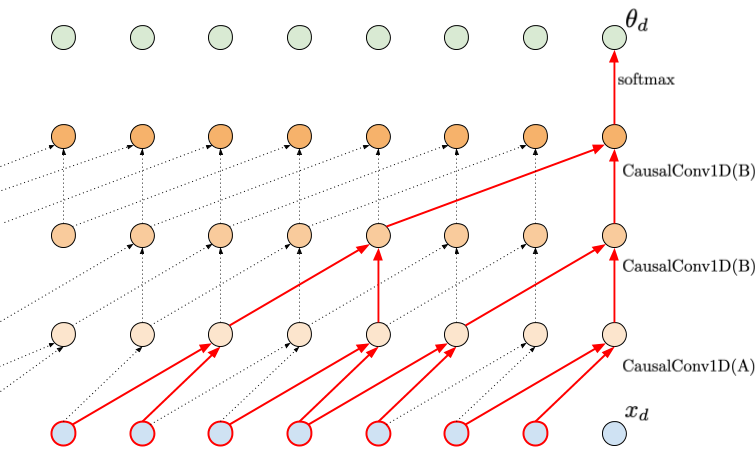


Causal convolutions allows *infinite memory*, where no memory length is defined. For this purpose the dilation process inflates a given kernel as per a dilation factor prior to the process, that elarge dependencies.

Modeling $p(x)$ via ARM based CausalConv allows us to parametrize the Θ parametrizing the following conditionnal probabilities : 
$$ p_Θ(x_d|x_{<d})$$






### Autoregressive Model

The autoregressive model is parameterized by causal convolutions. Please remember that we must decide on the form of the distribution of conditionals (e.g., Bernoulli, Gaussian, Categorical).

In [26]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following functions:
# (i) sample
# (ii) log_prob
# Moreover, forward must return the log-probability of the likelihood function for given x, i.e., log p(x)
# Remember that the ARM is parameterized by a neural net composed of causal convolutional layers.
# Last, please remember you decide on the form of the distribution p(x_d|x_1:d-1) (e.g., Categorical, Gaussian)!

class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        super(ARM, self).__init__()

        self.net = net
        self.num_vals = num_vals
        self.D = D
    # Get MLP values and get proba
    def f(self, x):
        h = self.net(x.unsqueeze(1))

        h = h.permute(0, 2, 1)
        p = torch.softmax(h, 2)
        return p

    def log_prob(self, x):
        mu_d = self.f(x)
        log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='mean', dim=-1).sum(-1)

        return log_p

    def sample(self, batch_size):

        # output: a sample from p(x|z)
        # HINT: this could be implemented using a for-loop
        x_new = torch.zeros((batch_size, self.D))

        for d in range(self.D):
            p = self.f(x_new)
            x_new_d = torch.multinomial(p[:, d, :], num_samples=1)
            x_new[:, d] = x_new_d[:,0]

        return x_new

    def forward(self, x, reduction='mean'):
        if reduction == 'mean':
            return -(self.log_prob(x).mean())
        elif reduction == 'sum':
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either `mean` or `sum`.')

Please answer the following questions:

#### Question 2

Please explain your choice of distribution for image data used in this assignment. Additionally, please write it down mathematically (if you think that presenting it as the log-probability, then please do it).

**ANSWER**:

* The colored data are they concerned by a categorial distribution
$$p_θ(\mathbf{x_d}|x_{<d}) \sim Categorical(x_d|θ_d(x_{<d})) $$ with
\begin{align}   
  \mathbf{x} \in \{0, 1\} \\
  \mathbf{θ}^d \in \{0, 1\} \\
  d \in [0, 16] \\
  𝐶𝑎𝑡𝑒𝑔𝑜𝑟𝑖𝑐𝑎𝑙(𝑥𝑑|θ𝑑(𝑥<𝑑)) = \prod^{L}_{l=1}(Θ_{d,l})^{x_d=l} 
\end{align}

#### Question 3

Please explain how one can sample from the distribution chosen by you. Please be specific and formal (i.e., provide mathematical formulae).

ANSWER: 


#### Question 4

Please explain why ARMs calculate the exact likelihood function.

ANSWER: [Please fill in]

### Evaluation and training functions

**Please DO NOT remove or modify them.**

In [27]:
# ==========DO NOT REMOVE==========

def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, _) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader, shape=(28,28)):
    # real images-------
    num_x = 4
    num_y = 4
    x, _ = next(iter(test_loader))
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, shape=(28,28), extra_name=''):
    x, _ = next(iter(data_loader))
    x = x.to('cpu').detach().numpy()

    # generations-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [28]:
# ==========DO NOT REMOVE==========

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, shape=(28,28)):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, (batch, _) in enumerate(training_loader):
            batch = batch.to(device)
            loss = model.forward(batch, reduction='mean')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, shape=shape, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Setup

**NOTE: *Please comment your code! Especially if you introduce any new variables (e.g., hyperparameters).***

In the following cells, we define `transforms` for the dataset. Next, we initialize the data, a directory for results and some fixed hyperparameters.

In [29]:
# PLEASE DEFINE APPROPRIATE TRANFORMS FOR THE DATASET
# (If you don't see any need to do that, then you can skip this cell)
# HINT: Please prepare your data accordingly to your chosen distribution in the decoder
#https://www.analyticsvidhya.com/blog/2021/04/10-pytorch-transformations-you-need-to-know/
# https://medium.com/@sergei740/simple-guide-to-custom-pytorch-transformations-d6bdef5f8ba2
#transforms_train = torchvision.transforms.Compose( #FILL IN
from torchvision import transforms
transforms_train = torchvision.transforms.Compose( [
                                                    #transforms.Resize((28,28)),
                                                    transforms.ToTensor(),  transforms.Lambda(lambda x: torch.flatten(x))
] )
transforms_test = torchvision.transforms.Compose( [
                                                    #transforms.Resize((28,28)),
                                                    transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))
] )


Please do not modify the code in the next cell.

In [30]:
# ==========DO NOT REMOVE==========
#-dataset
dataset = MNIST('/files/', train=True, download=True,
                      transform=transforms_train
                )

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

test_dataset = MNIST('/files/', train=False, download=True,
                      transform=transforms_test
                     )
#-dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#-creating a dir for saving results
name = 'arm'
result_dir = images_dir + 'results/' + name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

#-hyperparams (please do not modify them!)
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In the next cell, please initialize the model. Please remember about commenting your code!

In [31]:
# BASIC HYPERPARAMETERS
D = 784   # input dimension
M = 100  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 100 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped



In [32]:
# INIT YOUR VAE (PLEASE CALL IT model)
# AN EXAMPLE: model = ARM(causal_convnet, ...)



likelihood_type = 'categorical'

num_vals = 16

kernel = 4
dilatation= 8

net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=dilatation, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=dilatation, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=dilatation, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=dilatation, kernel_size=kernel, A=False, bias=True))

model = ARM(net, D=D, num_vals=num_vals)

# Print the summary (like in Keras)
print(summary(model, torch.zeros(1, 64), show_input=False, show_hierarchical=False))



model.to(device)

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
    CausalConv1d-1        [1, 100, 64]             500             500
       LeakyReLU-2        [1, 100, 64]               0               0
    CausalConv1d-3        [1, 100, 64]          40,100          40,100
       LeakyReLU-4        [1, 100, 64]               0               0
    CausalConv1d-5        [1, 100, 64]          40,100          40,100
       LeakyReLU-6        [1, 100, 64]               0               0
    CausalConv1d-7         [1, 16, 64]           6,416           6,416
Total params: 87,116
Trainable params: 87,116
Non-trainable params: 0
-----------------------------------------------------------------------


ARM(
  (net): Sequential(
    (0): CausalConv1d(
      (conv1d): Conv1d(1, 100, kernel_size=(4,), stride=(1,), dilation=(8,))
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): CausalConv1d(
      (conv1d): Conv1d(100, 100, kernel_size=(4,), stride=(1,), dilation=(8,))
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): CausalConv1d(
      (conv1d): Conv1d(100, 100, kernel_size=(4,), stride=(1,), dilation=(8,))
    )
    (5): LeakyReLU(negative_slope=0.01)
    (6): CausalConv1d(
      (conv1d): Conv1d(100, 16, kernel_size=(4,), stride=(1,), dilation=(8,))
    )
  )
)

Please initialize the optimizer

In [33]:
# PLEASE DEFINE YOUR OPTIMIZER
lr = 1e-3 # learning rate (PLEASE CHANGE IT AS YOU WISH!)
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

#### Question 5

Please explain the choice of the optimizer, and comment on the choice of the hyperparameters (e.g., the learning rate value).

ANSWER: [Please fill in]

### Training and final evaluation

In the following two cells, we run the training and the final evaluation.

In [34]:
train_loader


In [35]:
# ==========DO NOT REMOVE OR MODIFY==========
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience,
                   num_epochs=num_epochs, model=model, optimizer=optimizer,
                   training_loader=train_loader, val_loader=val_loader,
                   shape=(28,28))

Epoch: 0, val nll=3.8896546444892883
saved!
Epoch: 1, val nll=3.8889203555107117
saved!
Epoch: 2, val nll=3.8888434081077574
saved!
Epoch: 3, val nll=3.8888343382835386
saved!
Epoch: 4, val nll=3.8888343382835386
Epoch: 5, val nll=3.8888343382835386
Epoch: 6, val nll=3.8888343382835386
Epoch: 7, val nll=3.8888343382835386
Epoch: 8, val nll=3.8888343382835386
Epoch: 9, val nll=3.8888343382835386
Epoch: 10, val nll=3.8888343382835386
Epoch: 11, val nll=3.8888343382835386
Epoch: 12, val nll=3.8888343382835386
Epoch: 13, val nll=3.8888343382835386
Epoch: 14, val nll=3.8888343382835386


KeyboardInterrupt: 

In [ ]:
# ==========DO NOT REMOVE OR MODIFY==========
# Final evaluation
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + name, test_loader, extra_name='_FINAL')

plot_curve(result_dir + name, nll_val)

### Results and discussion

After a successful training of your model, we would like to ask you to present your data and analyze it. Please answer the following questions.

#### Question 6

Please select the real data, and the final generated data and include them in this report. Please comment on the following:
- Do you think the model was trained properly by looking at the generations? Please motivate your answer well.
- Compared to the previous assignment, could you say whether this model works better (or worse)? Why?

ANSWER: [Please fill in]

#### Question 7

Please include the plot of the likelihood function. Please comment on the following:
- Is the training of your ARM stable or unstable? Why?
- What is the influence of the optimizer on your model? Do the hyperparameter values of the optimizer important and how do they influence the training? Motivate well your answer (e.g., run the script with more than one learning rate and present two plots here).

ANSWER: [Please fill in]